First we will import the regular Python libraries that we have been using.

Normally you would import everything at the top here, but for demonstration purposes we will import functions as we need them.

In [5]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# # libraries and functions used throughout:

# from sklearn.model_selection import train_test_split

# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer

# from sklearn.ensemble import RandomForestRegressor

# from sklearn.metrics import mean_squared_error, r2_score

# from sklearn.model_selection import GridSearchCV

In [7]:
# FUNCTIONS

def plot_numerical_distributions(df, bins=int(50)):
    """
    Plots the distribution of all numerical features in the given DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing numerical features.
    bins (int): Number of bins for histograms (default: 30).
    """
    num_cols = df.select_dtypes(include=['number']).columns  # Select numerical columns
    num_features = len(num_cols)

    if num_features == 0:
        print("No numerical features found in the DataFrame.")
        return

    # Define the number of rows and columns for subplots
    rows = (num_features + 2) // 3  # 3 plots per row
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))  # Dynamic grid
    axes = axes.flatten() if num_features > 1 else [axes]  # Flatten if multiple plots

    for i, col in enumerate(num_cols):
        sns.histplot(df[col].dropna(), bins=bins, kde=True, ax=axes[i], color="steelblue")
        axes[i].set_title(f"Distribution of {col}", fontsize=12)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Count")

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def plot_categorical_distributions(df):
    """
    Plots the distribution of all categorical features in the given DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing categorical features.
    """
    cat_cols = df.select_dtypes(include=['object', 'category']).columns  # Select categorical columns
    cat_features = len(cat_cols)
    
    if cat_features == 0:
        print("No categorical features found in the DataFrame.")
        return
    
    # Define the number of rows and columns for subplots
    rows = (cat_features + 2) // 3  # 3 plots per row
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))  # Dynamic grid
    axes = axes.flatten() if cat_features > 1 else [axes]  # Flatten if multiple plots
    
    for i, col in enumerate(cat_cols):
        sns.countplot(data=df, x=col, ax=axes[i], palette="Set2",hue = col, legend = False)
        axes[i].set_title(f"Distribution of {col}", fontsize=12)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Count")
        axes[i].tick_params(axis='x', rotation=90)  # Rotate labels for readability
    
    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

Now, we will load the data.

This dataset is from: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

The way this dataset was set up was with the training data in one file which includes the target variable "SalePrice" (the depdendent variable that we want to predict). So we load them as seperate dataframes.

In [2]:
# LOAD DATA

folder = './house-prices-advanced-regression-techniques/'
fn_train = 'train.csv'
fn_test = 'test.csv'


train_data = pd.read_csv(folder + fn_train)
test_data = pd.read_csv(folder + fn_test)

With the data loaded, we now want to do some exploratory data analysis, also called EDA.

First we use the dataframe.describe() function to get a general overview of the statistics on each feature.

In [3]:
print(train_data.describe(include = 'all'))

train_data.info()

                 Id   MSSubClass MSZoning  LotFrontage        LotArea Street  \
count   1460.000000  1460.000000     1460  1201.000000    1460.000000   1460   
unique          NaN          NaN        5          NaN            NaN      2   
top             NaN          NaN       RL          NaN            NaN   Pave   
freq            NaN          NaN     1151          NaN            NaN   1454   
mean     730.500000    56.897260      NaN    70.049958   10516.828082    NaN   
std      421.610009    42.300571      NaN    24.284752    9981.264932    NaN   
min        1.000000    20.000000      NaN    21.000000    1300.000000    NaN   
25%      365.750000    20.000000      NaN    59.000000    7553.500000    NaN   
50%      730.500000    50.000000      NaN    69.000000    9478.500000    NaN   
75%     1095.250000    70.000000      NaN    80.000000   11601.500000    NaN   
max     1460.000000   190.000000      NaN   313.000000  215245.000000    NaN   

       Alley LotShape LandContour Utili

Next what we want to do is take a closer look at the target and also some of the features we think 
are the most interesting. What features do we think would be most important towards predicting the sale price?

One thing we could do is do a pair plot of all the features. I won't do that right now because when I tried
it earlier it was taking too long to run, so for this demonstration i will plot the histogram, so the distribution,
of some of the features of interest.

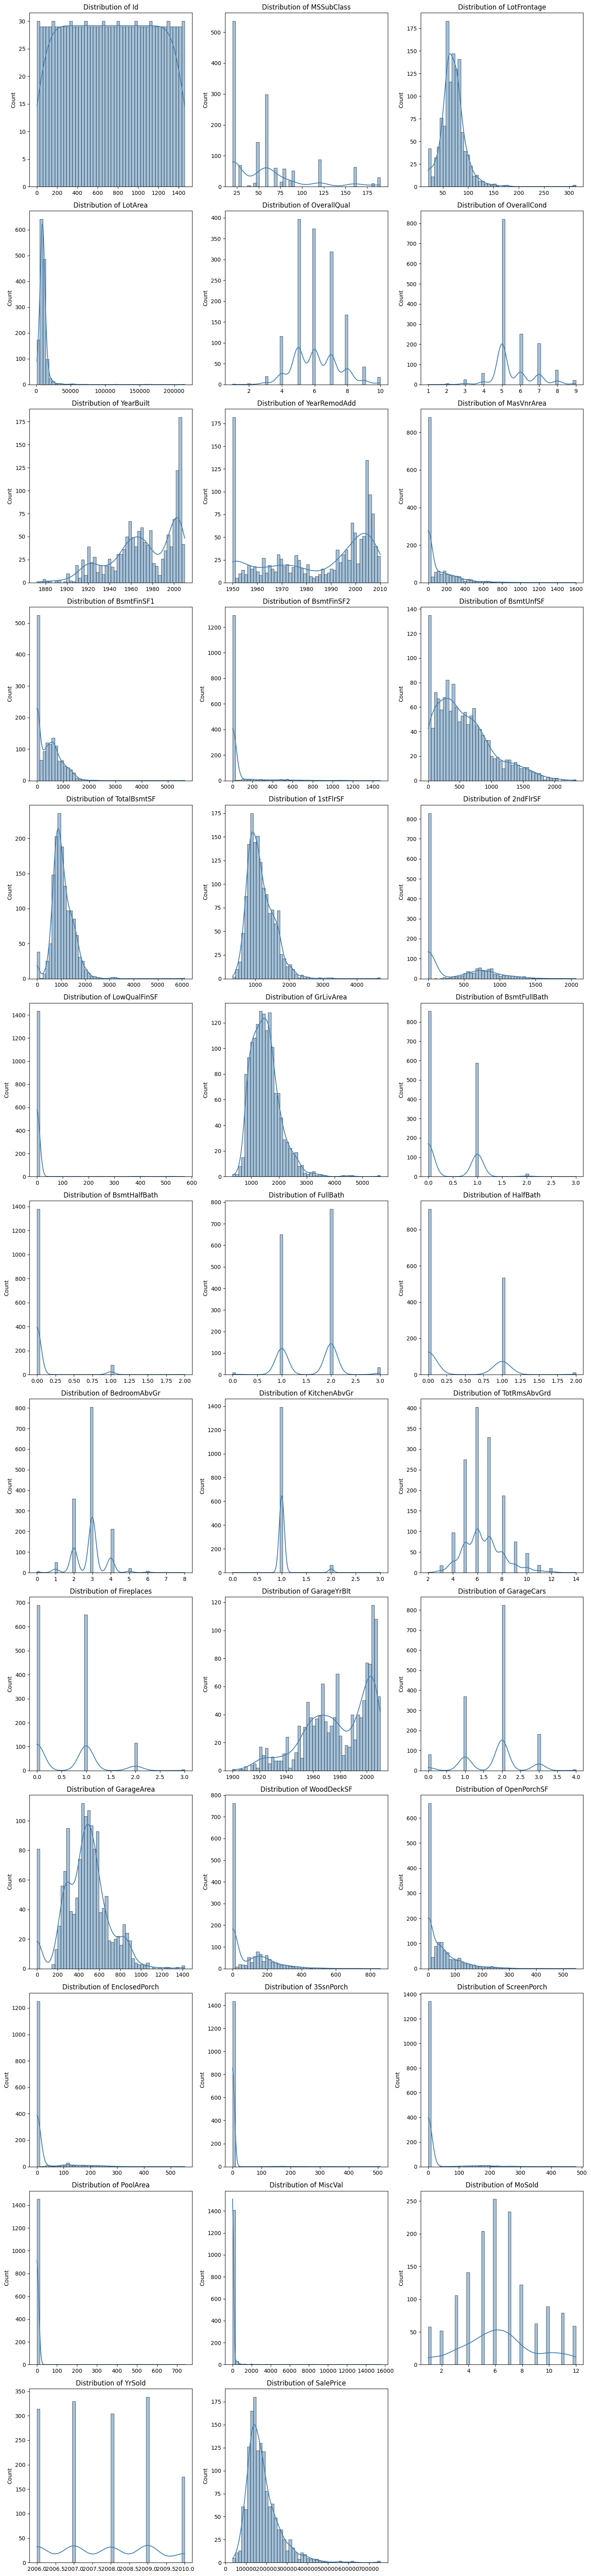

In [6]:
# # here is how we would plot the pairplot. notice how we take just the numerical features, not the categorical ones
# numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# # create the pairplot using sns.pairplot with the subset of numerical columns
# import seaborn as sns
# sns.pairplot(df[numerical_cols])

# general rule of thumb for number of bins in the square root of the number of datapoints
number_of_bins = int(np.sqrt(len(train_data['SalePrice'])))

plot_numerical_distributions(train_data)

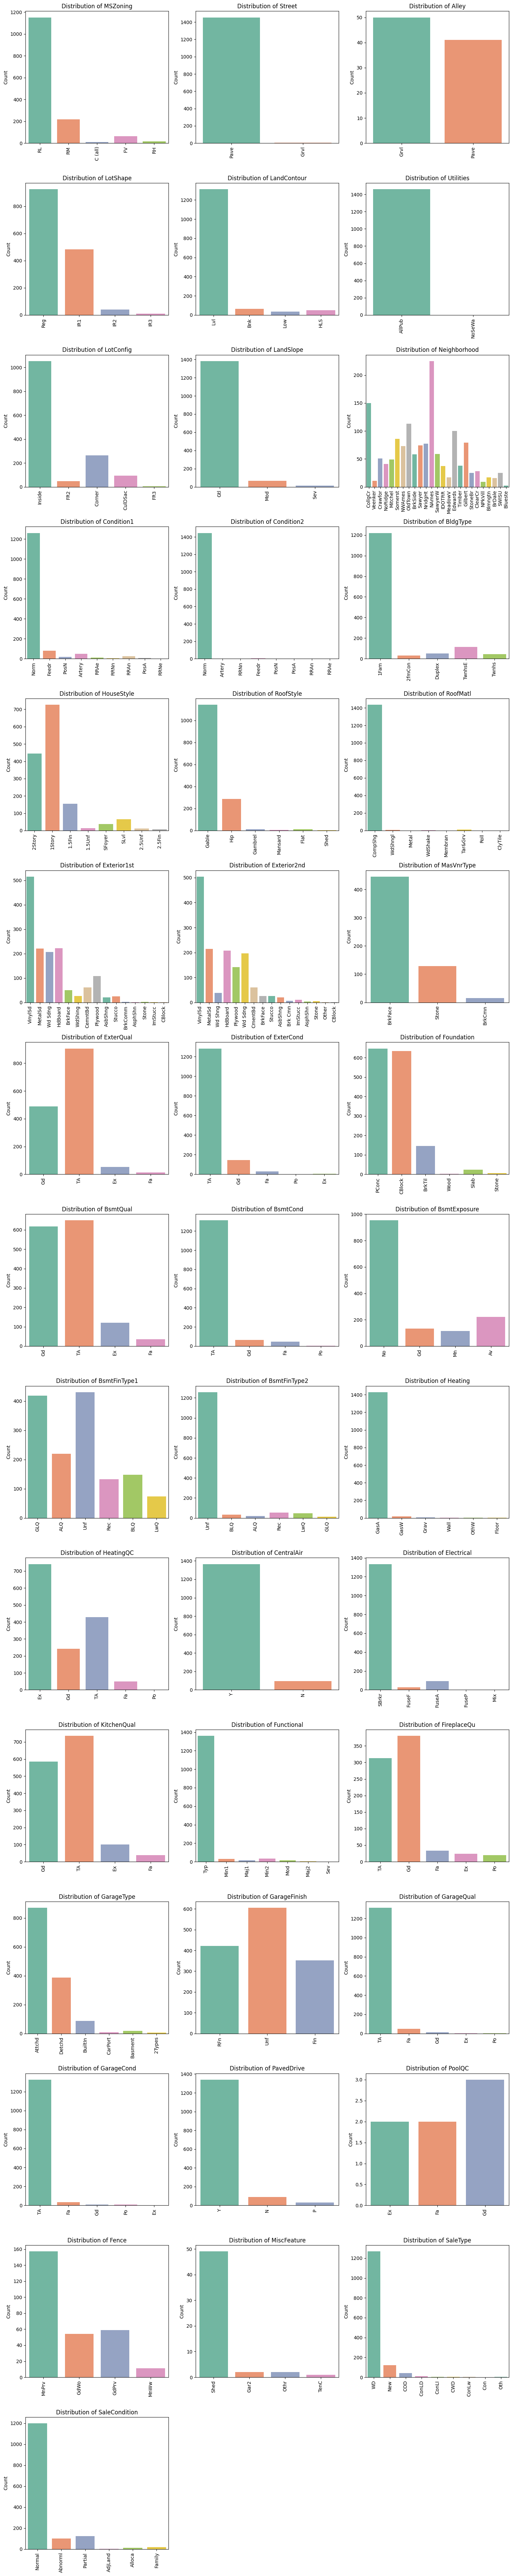

In [8]:
plot_categorical_distributions(train_data)

Now let's get an idea of how many NaN values we have in the dataframe. We will need to deal with these.

Here are some ideas to keep in mind when dealing with NaN values in your data:

- What percentage of the data are NaNs? If it's like 4% we can just drop them. If it's like 20% need to do   something. For example we could fill with a zero but need to think about if this makes sense. Could also take the average of the surrounding points.

- This act of filling in NaNs is called **imputation** and we will discuss this.

- Always need to fill or drop nans. Cannot send them to the model!! It's like putting $\infty$ into a math equation.

- Some models might warn you if there are nans.

- How many **ROWS** contain NaNs is a good question to ask.

In [9]:
# print each feature along with its number of NaN values

for idx,col in enumerate(train_data.isnull().sum()):
    print(train_data.columns[idx],col)
    
nan_rows = 0

# Iterate through each row (index) of the dataframe
for index in train_data.index:
    # Check if any element in the current row is NaN (using 'any' with isna())
    if train_data.iloc[index].isna().any():
        nan_rows += 1

# Print the number of rows with NaN values
print(f'Number of rows with NaN values: {nan_rows}')

nan_count = train_data.isna().sum().sum()

print()

print(f'{round(100 * nan_count / np.size(train_data),2)}% of the data is a NaN')

Id 0
MSSubClass 0
MSZoning 0
LotFrontage 259
LotArea 0
Street 0
Alley 1369
LotShape 0
LandContour 0
Utilities 0
LotConfig 0
LandSlope 0
Neighborhood 0
Condition1 0
Condition2 0
BldgType 0
HouseStyle 0
OverallQual 0
OverallCond 0
YearBuilt 0
YearRemodAdd 0
RoofStyle 0
RoofMatl 0
Exterior1st 0
Exterior2nd 0
MasVnrType 872
MasVnrArea 8
ExterQual 0
ExterCond 0
Foundation 0
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinSF1 0
BsmtFinType2 38
BsmtFinSF2 0
BsmtUnfSF 0
TotalBsmtSF 0
Heating 0
HeatingQC 0
CentralAir 0
Electrical 1
1stFlrSF 0
2ndFlrSF 0
LowQualFinSF 0
GrLivArea 0
BsmtFullBath 0
BsmtHalfBath 0
FullBath 0
HalfBath 0
BedroomAbvGr 0
KitchenAbvGr 0
KitchenQual 0
TotRmsAbvGrd 0
Functional 0
Fireplaces 0
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageCars 0
GarageArea 0
GarageQual 81
GarageCond 81
PavedDrive 0
WoodDeckSF 0
OpenPorchSF 0
EnclosedPorch 0
3SsnPorch 0
ScreenPorch 0
PoolArea 0
PoolQC 1453
Fence 1179
MiscFeature 1406
MiscVal 0
MoSold 0
YrS

We can see that there are NaN values. We will first define $X$ and $y$ along with splittng the data, and then do the preprocessing. 

Preprocessing involes:

- imputing the data (filling in the NaN values)
- scaling the numerical data so that all of the features are in the same range
- encoding the categorical variables

This step is splitting the data from 'train.csv' into training and validation subsets.

The training data will be used to train the model. The validation data will be used to estimate the performance of the model we will set up. In the case of this data, we have the "known target values" for the training (and therefore the validation) data, but the test data has no "known value" (you can check 'test.csv', there is no 'SalePrice' column.

We will use the 80/20 split.

In [10]:
# split for training and testing
from sklearn.model_selection import train_test_split

X = train_data.drop(columns=['SalePrice']) # set the features to be every column except for sale price
y = train_data['SalePrice'] # set the target to be sale price

# split the training data into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

# this is just calling the testing features X_test for symmetry with the training data. 
# there is no y_test, that is for us to calculate
X_test = test_data 

Now with $X$ and $y$ defined we can carry out the preprocessing.

Sources:

SimpleImputer: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

StandardScalar: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

OneHotEncoder: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

One hot encoding further explained: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

First we get the numeric features as a list, and the categorical features as list.

Next we use the "numeric_transformer" to set how we want to deal with missing values, as well as scaling the features to be similar. The "categorical_transformer" does the same thing with the categorical variables which are described by strings as opposed to numbers.

Last we define the preprocessor, where we apply the numerical transformer to the numerical data and we apply the categorical transformer to the categorical data.

This pre processing will then be combined with the regression model later.

In [11]:
# PREPROCESSING STEPS FOR NUMERICAL AND CATEGORICAL FEATURES

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# this gets the numeric features as a list, these will either be an integer or a float
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# similarly this gets the categorical features as a list. these are strings and not numbers, for example could be 'yes' or 'no'
categorical_features = X.select_dtypes(include=['object']).columns

# this defines how we want to transform the numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # here we replace every missing or NaN value with the mean of the features
    ('scaler', StandardScaler()) # here we scale every feature such that its mean is 0 and standard deviation is 1
])


# this defines how we want to transform the categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # here we replace every missing or NaN value with the most commonly occuring label
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # this converts the categorical variables. check the link for more of a description
])


# this now applies the column transforms we just defined
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features), # define the process as the name 'num', and tell sklearn to apply the numeric transformer we defined the the numeric features we got into the list
        ('cat', categorical_transformer, categorical_features) # same with the categorical variables
    ])

We are now ready to define our regression model

For this analysis we will be using the scikit-lean RandomForestRegressor. This comes from the sklearn.ensemble library which is a set of **ensemble** methods, meaning methods that involve multiple sub-methods. In this case, the data is put through a random forest before the regression is calculated.

A decision tree in ML is essentially a set of if and else statements to subset data. A decision tree in ML is essentially a set of if and else statements to subset data. A random forest is a collection of decision trees where the if else statements are slightly different to get a more robust estimate.

It is useful here to consider because there are many features to consider which affect the final sale price.

The hyperparameter in the sklearn RandomForestRegressor is called n_estimators which is the number of decision trees. A higher number will vary more of the parameters and can give you a more accurate result, but will take longer to compute. Also you want to be careful of overfitting.

RandomForestRegressor docs: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [8]:
# define random forest regressor model
from sklearn.ensemble import RandomForestRegressor

number_of_trees = 100 # set the number of trees in the forest
model = RandomForestRegressor(n_estimators=number_of_trees, random_state=42) # define model. n_estimators is the hyperparameter which we will later tune

With the Random Forest Regression model defined, we now combine it with the preprocessing that we defined.

Together this forms the 'full_model'. This model will then be trained (also known as 'fit'), and then used to make predictions.

In [9]:
# define full model

full_model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', model)]) # this leaves the data unchanged

With the full model defined, it can now be fit using the **TRAINING DATA**.

This is where the model attempts to learn the underlying patterns.

Since there are many dimensions this is why it is useful to use a regression model that first uses a random forest to subset the data.

In [10]:
# fit model to data

'''
do not need to convert the dataframes to no arrays anymore, FOR THE MOST PART.
check the docs for which ever algorithm you are using
'''

full_model.fit(X_train, y_train)
None # I just put this here to suppress the output of full_model.fit(X_train, y_train). if you want you can delete this line and see what happens

With our model defined and trained, we can now make predictions on the **VALIDATION DATA**.

The terminology might be slightly confusing compared to the ML2 session where we made predictions on the test data.

Terminology in ML can be loose in general. The concepts are more important than the words.

In this specific case, we have the known values of the validation data. Meaning we have the house price of these rows.

We will "predict" the sale price, and then compare these predicted values to the known values in order to get an estimation of the model's performance.

We can evaluate the model performance by calculating the root mean squared error (RMSE) and R square ($R^2$).

RMSE quantifies the average difference between the predicted values by your model and the actual values in your data. The lower the RMSE, the better the model fits the data, indicating a smaller average difference between predictions and actual values.

R square is a statistical measure that represents the proportion of variance (spread) in the target variable that your model explains. A higher R square value (closer to 1) indicates a better fit, meaning your model explains a larger proportion of the variance in the target variable. An R square of 0 means the model explains none of the variance, essentially the same as predicting the average value for all data points.


In [11]:
from sklearn.metrics import mean_squared_error, r2_score

# make predictions on VALIDATION DATA
y_val_pred = full_model.predict(X_val)

# evaluate model performance

# calculate mean squared error, this tells us the average squared difference between the predicted and true values. so let's take the square root
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred)) # root mean squared error

# r^2 tells us how well the model explains the variance in the data. an r^2 of 1 is a perfect correlation and a r^2 of  0 is no correlation
val_r2 = r2_score(y_val, y_val_pred)

# print out the metrics we just calculated
print(f"Validation RMSE: {val_rmse}") # this number is very large so we print the log10 of it
print(f"Validation R2 Score: {val_r2}")

Validation RMSE: 28561.708782396403
Validation R2 Score: 0.8936458259355333


The R^2 we calculated looks good but the RMSE seems high. Let's compare it to the mean of the training target to get an idea of the RMSE as a percentage of the mean value.

In [12]:
print(val_rmse/np.mean(y_train))

# so the error is like 15%

0.1574154875179782


We now have an idea of the model's performance from the root mean squared error and $R^2$ (R squared) metrics.

Let's now make a scatter plot comparing the "predicted" values to the actual values.

Keep in mind this plot is telling us how well we made predictions on the **TRAINING DATA**. So it should follow very close to a straight line with slope = 1.

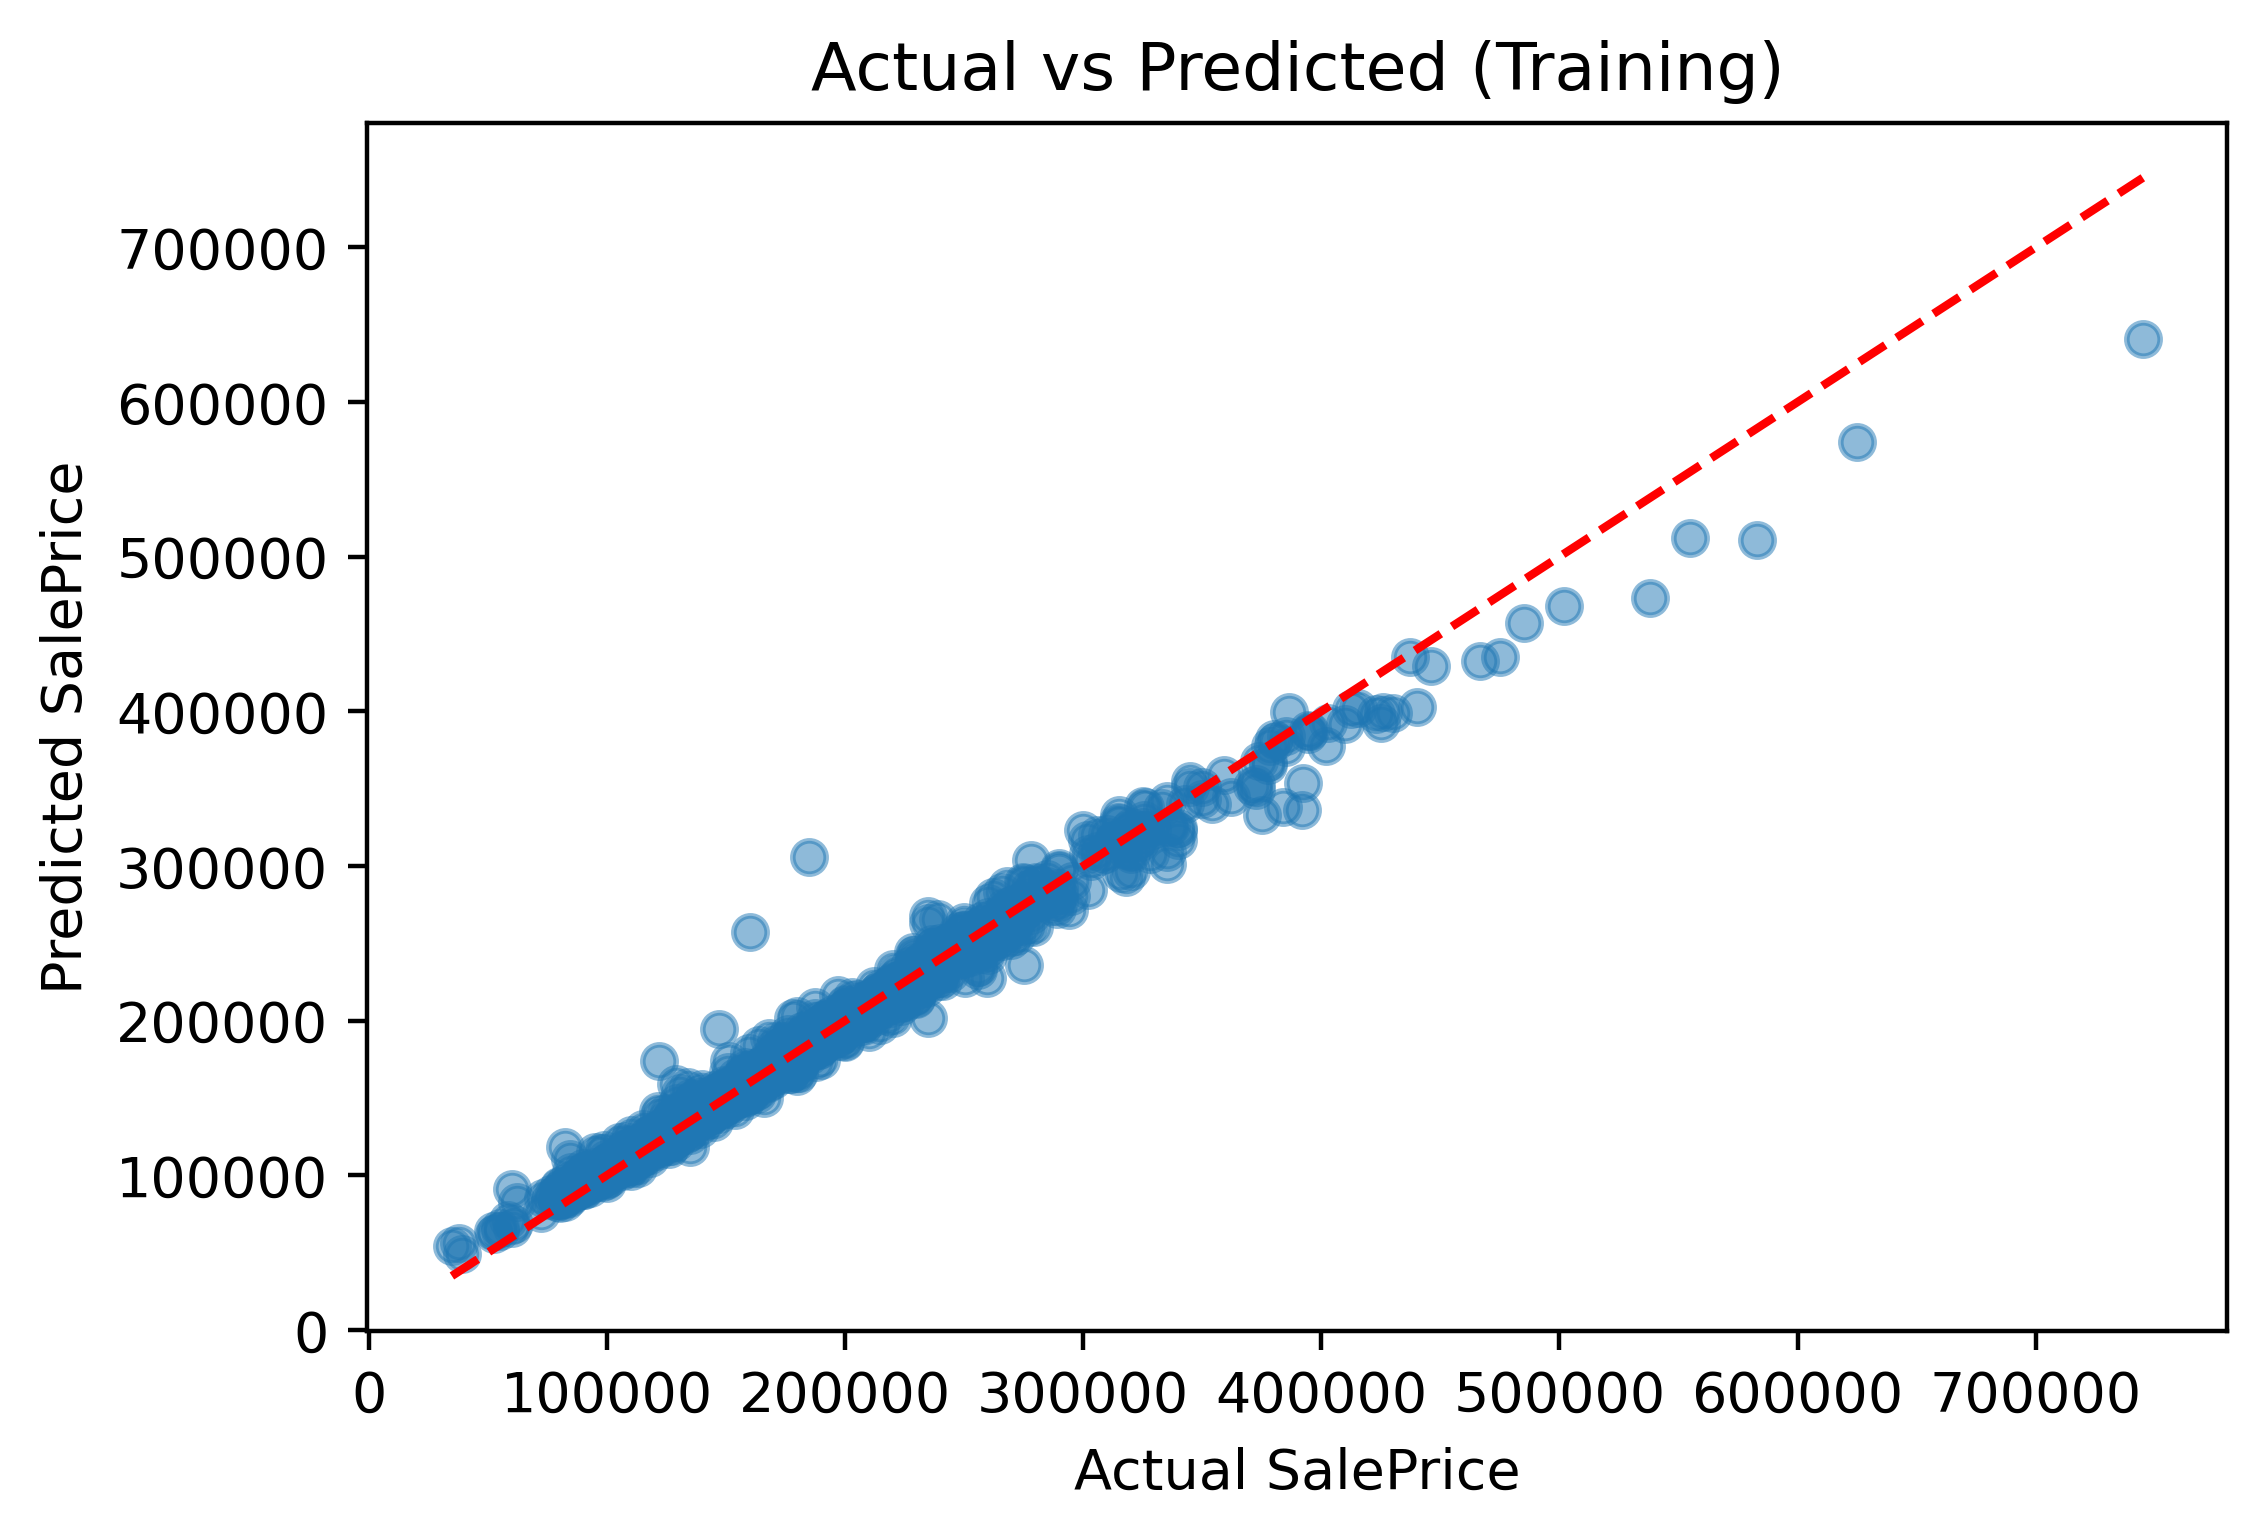

In [13]:
# plot actual versus predicted for training set

# this is how well the model fits the training set it was trained on

y_train_pred = full_model.predict(X_train)

plt.figure(dpi = 400)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], '--', color='red')
plt.title("Actual vs Predicted (Training)")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.show()

Now let's see how well the model generalizes to the "unknown" data which is in the **VALIDATION SET**.

In this specific instance what I mean by unknown is that the model did not see this data during the training step.

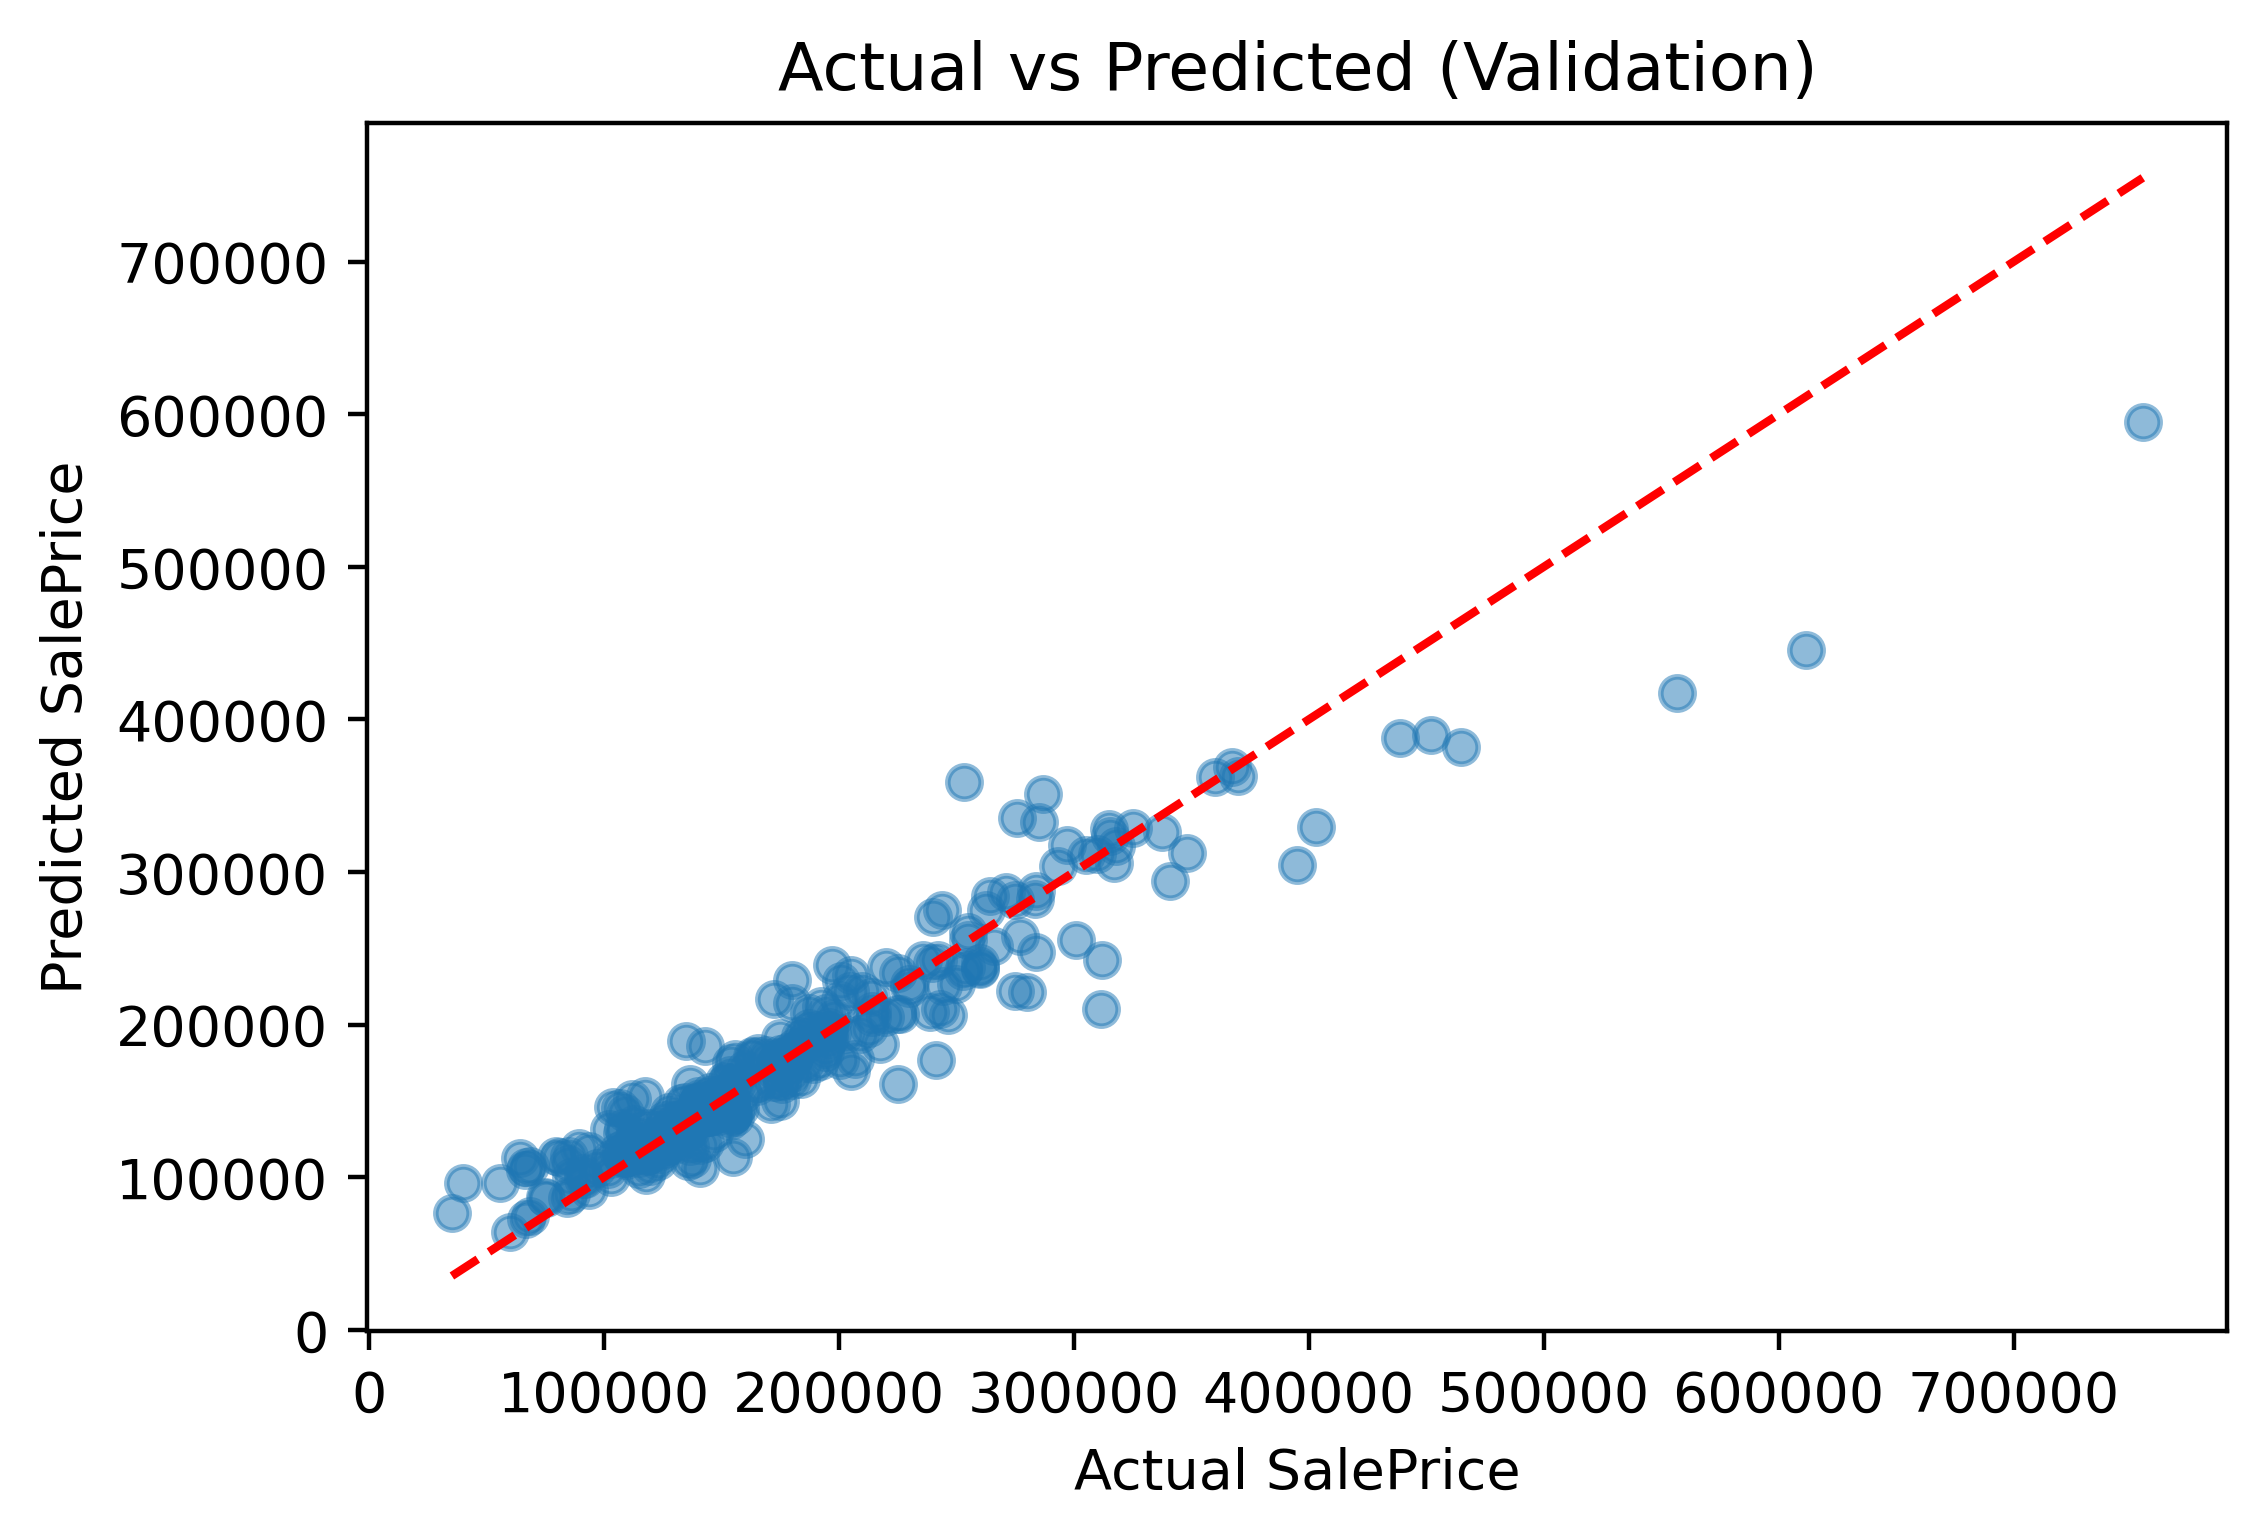

In [14]:
# plot actual vs predicted for validation set

# this shows how the model performs on data it wasn't trained on. gives idea of how well it generalizes to new data

plt.figure(dpi = 400)
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red')
plt.title("Actual vs Predicted (Validation)")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.show()

The model is working ok, but could it be improved?

Let's use hyperparameter tuning to find the best number of trees to use in the forest. This will effect how the data gets put into subsets before calculating the regression.

In [15]:
# HYPERPARAMETER TUNING

from sklearn.model_selection import GridSearchCV

# define hyperparameters and their range
param_grid = {'regressor__n_estimators': [50,100,150,200]} # first guess for n_estimator
# param_grid = {'regressor__n_estimators': [146,148,150,152,154]} # with it narrowed down we can try finer tuning

# create gridsearchcv object
grid_search = GridSearchCV(estimator=full_model, # we want to send the pre processing the ML model to the grid search
                           param_grid = param_grid,
                           scoring = 'r2', # let's use r squared to determine the best model
                           cv = 5) # this is 5 folds, GridSearchCV automatically does cross validation for us!


grid_search.fit(X_train, y_train) # now use the grid search to fit the training data to find the optimal hyperparameters (in this case just one)

# get the best parameters (the n_estimators which resulted in the best r^2 value)
best_params = grid_search.best_params_

# print the best parameter
print(best_params)

# {'regressor__n_estimators': 150}

{'regressor__n_estimators': 150}


With our optimized value for n_estimators we can now re fit the model and see if the perfomance shifts.

In [16]:
# define random forest regressor model
from sklearn.ensemble import RandomForestRegressor

number_of_trees = best_params['regressor__n_estimators'] # set the number of trees in the forest to the optimzed value
model_optimized = RandomForestRegressor(n_estimators=number_of_trees, random_state=42) # define model. n_estimators is the hyperparameter which we will later tune

# define full optimized model
full_model_optimized = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', model_optimized)])

# fit model to data
full_model_optimized.fit(X_train, y_train)

# make predictions on validation data with optimized model
y_val_pred = full_model_optimized.predict(X_val)

# calculate metrics on optimized model
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"log Validation MSE: {np.log10(val_mse)}")
print(f"Validation R2 Score: {val_r2}")

log Validation MSE: 8.907957685401612
Validation R2 Score: 0.8945263801623626


Our metrics don't change too much... let's plot the new predictions on the validation data and examine.

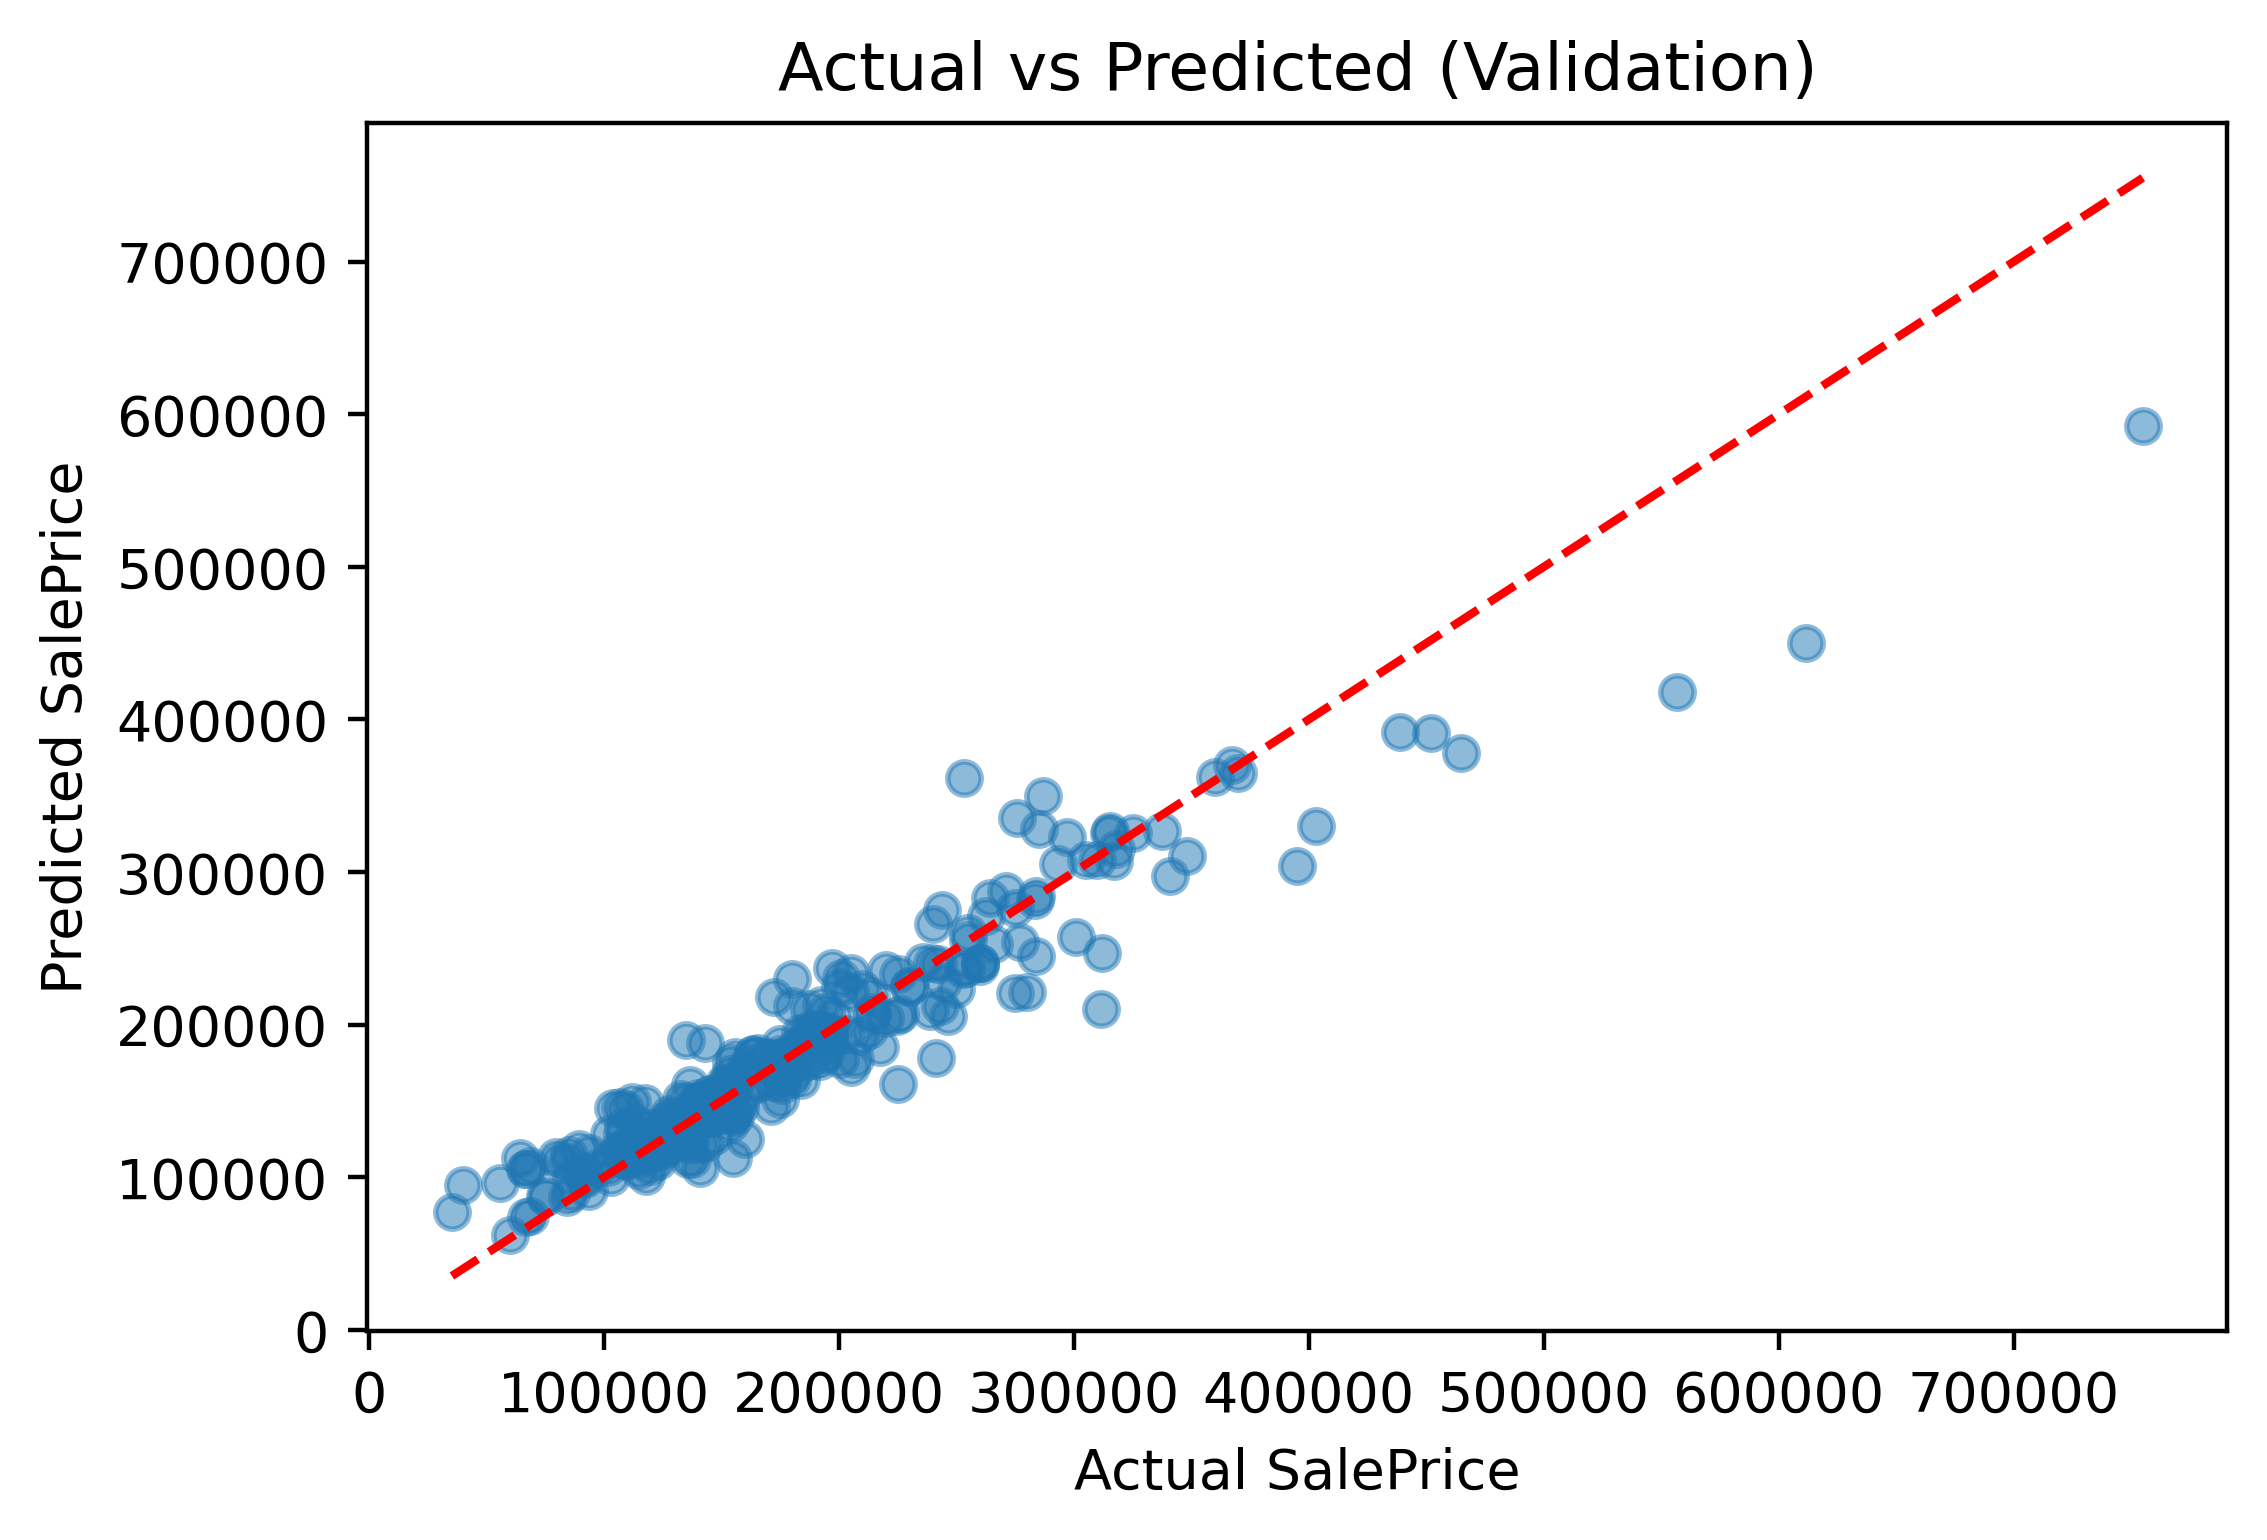

In [17]:
plt.figure(dpi = 400)
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='red')
plt.title("Actual vs Predicted (Validation)")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.show()